In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import newton, minimize

In [107]:
close_prices = pd.read_excel("bond data full.xlsx", sheet_name='Close Price')
bond_stats = pd.read_excel("bond data full.xlsx", sheet_name='Info')

In [108]:
bond_stats.head()

,ISIN,Coupon,Issue Date,Maturity Date
0,CA135087B451,0.0250,2013-07-02,2024-06-01
1,CA135087D507,0.0225,2014-06-30,2025-06-01
2,CA135087E679,0.0150,2015-07-21,2026-06-01
3,CA135087J546,0.0225,2018-10-05,2024-03-01
4,CA135087J967,0.0150,2019-04-05,2024-09-01


In [109]:
melted_df = close_prices.melt(id_vars=['ISIN'], var_name='Date', value_name='Close')
melted_df['Date'] = pd.to_datetime(melted_df['Date']).dt.date
melted_df

,ISIN,Date,Close
0,CA135087B451,2024-01-08,99.037
1,CA135087D507,2024-01-08,97.399
2,CA135087E679,2024-01-08,94.970
3,CA135087J546,2024-01-08,99.630
4,CA135087J967,2024-01-08,97.960
...,...,...,...
425,CA135087Q723,2024-01-19,98.010
426,CA135087Q988,2024-01-19,102.242
427,CA135087VW17,2024-01-19,113.620
428,CA135087WL43,2024-01-19,111.050


In [110]:
data_df = melted_df.merge(bond_stats, on='ISIN', how='left')
data_df

,ISIN,Date,Close,Coupon,Issue Date,Maturity Date
0,CA135087B451,2024-01-08,99.037,0.0250,2013-07-02,2024-06-01
1,CA135087D507,2024-01-08,97.399,0.0225,2014-06-30,2025-06-01
2,CA135087E679,2024-01-08,94.970,0.0150,2015-07-21,2026-06-01
3,CA135087J546,2024-01-08,99.630,0.0225,2018-10-05,2024-03-01
4,CA135087J967,2024-01-08,97.960,0.0150,2019-04-05,2024-09-01
...,...,...,...,...,...,...
425,CA135087Q723,2024-01-19,98.010,0.0325,2023-06-26,2033-12-01
426,CA135087Q988,2024-01-19,102.242,0.0400,2023-10-13,2029-03-01
427,CA135087VW17,2024-01-19,113.620,0.0800,1996-05-01,2027-06-01
428,CA135087WL43,2024-01-19,111.050,0.0575,1998-02-02,2029-06-01


### Choosing 10-11 suitable bonds

In [111]:
bond_isins = ['CA135087J546', 'CA135087J967', 'CA135087K528','CA135087K940','CA135087L518','CA135087L930','CA135087M847','CA135087N837', 'CA135087P576','CA135087Q491', 'CA135087Q988']
chosen_bonds = data_df.loc[data_df['ISIN'].isin(bond_isins)]
chosen_bonds = chosen_bonds.sort_values(by=['ISIN', 'Date'])
chosen_bonds

,ISIN,Date,Close,Coupon,Issue Date,Maturity Date
3,CA135087J546,2024-01-08,99.630,0.0225,2018-10-05,2024-03-01
46,CA135087J546,2024-01-09,99.640,0.0225,2018-10-05,2024-03-01
89,CA135087J546,2024-01-10,99.650,0.0225,2018-10-05,2024-03-01
132,CA135087J546,2024-01-11,99.661,0.0225,2018-10-05,2024-03-01
175,CA135087J546,2024-01-12,99.670,0.0225,2018-10-05,2024-03-01
...,...,...,...,...,...,...
254,CA135087Q988,2024-01-15,103.552,0.0400,2023-10-13,2029-03-01
297,CA135087Q988,2024-01-16,102.974,0.0400,2023-10-13,2029-03-01
340,CA135087Q988,2024-01-17,102.483,0.0400,2023-10-13,2029-03-01
383,CA135087Q988,2024-01-18,102.279,0.0400,2023-10-13,2029-03-01


In [112]:
def calculate_dirty_price(bonds_df):
    face_value = 100  
    dirty_prices = []

    for _, bond in bonds_df.iterrows():
        valuation_date = pd.to_datetime(bond['Date'])
        issue_date = pd.to_datetime(bond['Issue Date'])

        # Calculate the number of days in the coupon period
        coupon_period = 182 if issue_date.month in [3, 6, 9, 12] else 181
        
        # Calculate the number of days since the last coupon payment
        days_since_issue = (valuation_date - issue_date).days
        days_since_last_coupon = days_since_issue % coupon_period
        
        accrued_interest = (bond['Coupon'] * face_value) * (days_since_last_coupon / 365)
        
        dirty_price = bond['Close'] + accrued_interest
        dirty_prices.append(dirty_price)
    
    bonds_df['Dirty Price'] = dirty_prices
    return bonds_df


def bond_ytm(price, par, T, coupon, freq=2, guess=0.05):
    """
    price: the bond's current clean price
    par: face value of the bond
    T: time to maturity in years
    coupon: the bond's coupon payment
    freq: number of coupon payments per year
    guess: initial guess for the yield to maturity
    """
    coupon = coupon * par / freq
    dates = np.arange(1, T * freq + 1)
    dt = (dates - 1) / freq
    
    # Define the function for calculating the current bond price based on YTM
    def price_func(ytm):
        return sum(coupon / (1 + ytm / freq)**(freq * t) for t in dt) + par / (1 + ytm / freq)**(freq * T) - price
    
    # Use newton method
    return newton(price_func, guess)


def append_ytm_column(bonds_df):
    ytms = []
    for index, bond in bonds_df.iterrows():
        T = (  pd.to_datetime(bond['Maturity Date']) - pd.to_datetime(bond['Date'])).days / 365
        ytm = bond_ytm(bond['Dirty Price'], 100, T, bond['Coupon'], freq=2)
        ytms.append(ytm)
        
    bonds_df['ytm'] = ytms
    return bonds_df



bonds_dirty_prices = calculate_dirty_price(chosen_bonds)
bonds_df_with_ytm = append_ytm_column(bonds_dirty_prices)
bonds_df_with_ytm



,ISIN,Date,Close,Coupon,Issue Date,Maturity Date,Dirty Price,ytm
3,CA135087J546,2024-01-08,99.630,0.0225,2018-10-05,2024-03-01,100.314247,0.056856
46,CA135087J546,2024-01-09,99.640,0.0225,2018-10-05,2024-03-01,100.330411,0.056788
89,CA135087J546,2024-01-10,99.650,0.0225,2018-10-05,2024-03-01,100.346575,0.056718
132,CA135087J546,2024-01-11,99.661,0.0225,2018-10-05,2024-03-01,100.363740,0.056570
175,CA135087J546,2024-01-12,99.670,0.0225,2018-10-05,2024-03-01,100.378904,0.056570
...,...,...,...,...,...,...,...,...
254,CA135087Q988,2024-01-15,103.552,0.0400,2023-10-13,2029-03-01,104.582137,0.033555
297,CA135087Q988,2024-01-16,102.974,0.0400,2023-10-13,2029-03-01,104.015096,0.034773
340,CA135087Q988,2024-01-17,102.483,0.0400,2023-10-13,2029-03-01,103.535055,0.035814
383,CA135087Q988,2024-01-18,102.279,0.0400,2023-10-13,2029-03-01,103.342014,0.036245


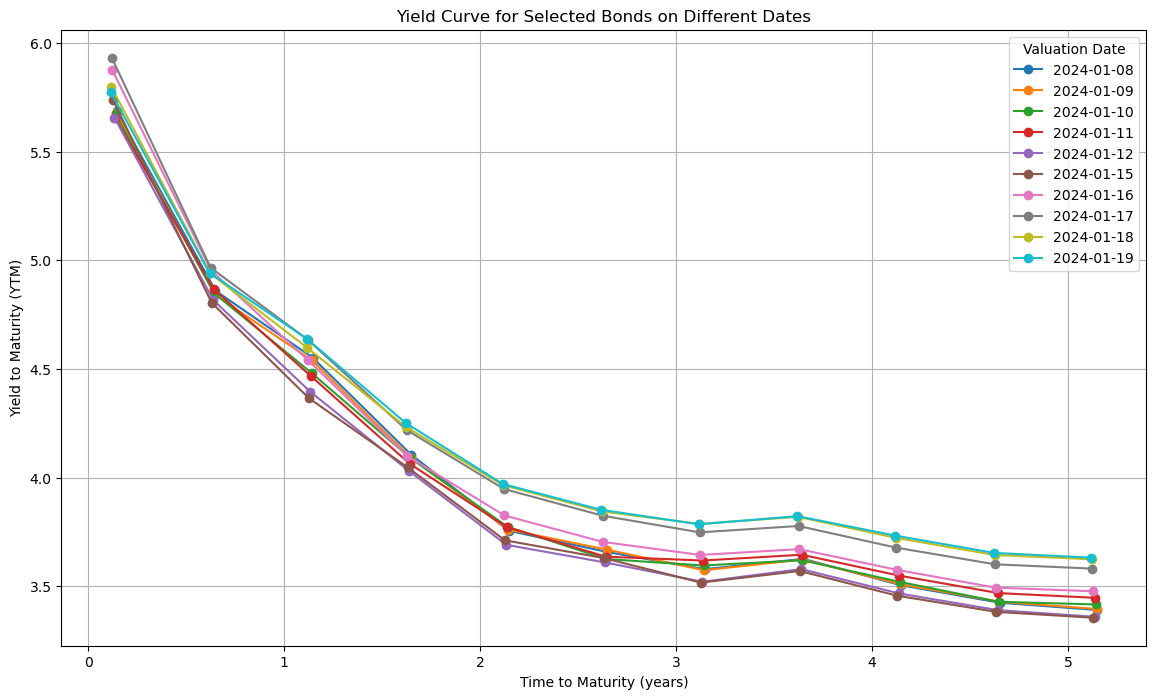

In [113]:
bonds_df_with_ytm['Maturity Date'] = pd.to_datetime(bonds_df_with_ytm['Maturity Date'])
# Calculate time to maturity in years
bonds_df_with_ytm['Time to Maturity'] = (pd.to_datetime(bonds_df_with_ytm['Maturity Date']) - pd.to_datetime(bonds_df_with_ytm['Date'])).dt.days / 365

# Plot the yield curve for each date
plt.figure(figsize=(14, 8))

for date in bonds_df_with_ytm['Date'].unique():
    date_df = bonds_df_with_ytm[bonds_df_with_ytm['Date'] == date]
    date_df = date_df.sort_values(by='Time to Maturity')
    plt.plot(date_df['Time to Maturity'], date_df['ytm']*100, marker='o', label=pd.to_datetime(date).date())

plt.xlabel('Time to Maturity (years)')
plt.ylabel('Yield to Maturity (YTM)')
plt.title('Yield Curve for Selected Bonds on Different Dates')
plt.legend(title='Valuation Date')
plt.grid(True)
plt.show()

## Bootstrapping Spot Rates

In [114]:
bonds = [(row['Dirty Price'], row['Coupon'], row['Time to Maturity']) for index, row in bonds_df_with_ytm.iterrows()]
         

def bootstrap_yield_curve(bonds):
    spot_rates = np.zeros(len(bonds))
    
    for i, (price, coupon_rate, maturity) in enumerate(sorted(bonds, key=lambda x: x[2])):
        num_periods = int(np.ceil(maturity * 2))  # Convert years to semi-annual periods
        cash_flows = np.array([coupon_rate / 2 * 100] * num_periods)  # Semi-annual coupon payments
        cash_flows[-1] += 100  
        
        def objective(spot_rate):
            pv_cash_flows = sum(cash_flows[j] / (1 + spot_rate / 2) ** (j+1) for j in range(num_periods))
            return (pv_cash_flows - price) ** 2
        
        guess = coupon_rate if i == 0 else spot_rates[i-1]
        
        result = minimize(objective, guess, method='SLSQP', bounds=[(0, None)])
        spot_rates[i] = result.x[0] if result.success else np.nan

    return spot_rates

spot_rates = bootstrap_yield_curve(bonds)

bonds_df_with_ytm['Spot Rate'] = spot_rates[:len(bonds_df_with_ytm)]

bonds_df_with_ytm


,ISIN,Date,Close,Coupon,Issue Date,Maturity Date,Dirty Price,ytm,Time to Maturity,Spot Rate
3,CA135087J546,2024-01-08,99.630,0.0225,2018-10-05,2024-03-01,100.314247,0.056856,0.145205,0.012996
46,CA135087J546,2024-01-09,99.640,0.0225,2018-10-05,2024-03-01,100.330411,0.056788,0.142466,0.013362
89,CA135087J546,2024-01-10,99.650,0.0225,2018-10-05,2024-03-01,100.346575,0.056718,0.139726,0.013988
132,CA135087J546,2024-01-11,99.661,0.0225,2018-10-05,2024-03-01,100.363740,0.056570,0.136986,0.014170
175,CA135087J546,2024-01-12,99.670,0.0225,2018-10-05,2024-03-01,100.378904,0.056570,0.134247,0.014153
...,...,...,...,...,...,...,...,...,...,...
254,CA135087Q988,2024-01-15,103.552,0.0400,2023-10-13,2029-03-01,104.582137,0.033555,5.128767,0.030961
297,CA135087Q988,2024-01-16,102.974,0.0400,2023-10-13,2029-03-01,104.015096,0.034773,5.126027,0.031780
340,CA135087Q988,2024-01-17,102.483,0.0400,2023-10-13,2029-03-01,103.535055,0.035814,5.123288,0.031515
383,CA135087Q988,2024-01-18,102.279,0.0400,2023-10-13,2029-03-01,103.342014,0.036245,5.120548,0.031339


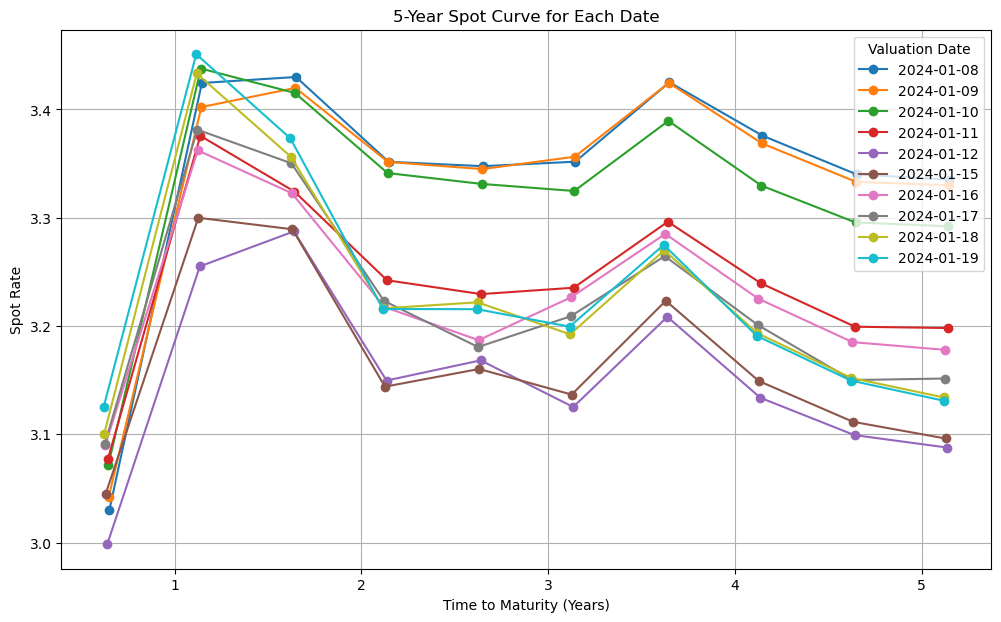

In [115]:
# Plot the spot rate curve for each date
plt.figure(figsize=(12, 7))

# Group the dataframe by 'Date' and plot each group
for date, group in bonds_df_with_ytm.groupby('Date'):
    plt.plot(group['Time to Maturity'][1:], group['Spot Rate'][1:]*100, marker='o', label=date.strftime('%Y-%m-%d'))

plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Spot Rate')
plt.title('5-Year Spot Curve for Each Date')
plt.legend(title='Valuation Date')
plt.grid(True)
plt.show()


In [116]:
def calculate_forward_rate(s1, s2, t_shorter, t_longer):
    """    
    s1: the spot rate at time t_shorter
    s2: the spot rate at time t_longer
    t_shorter: the starting time in years
    t_longer: the ending time in years
    
    Returns the annualized forward rate.
    """
    forward_rate = ((1 + s2)**t_longer / (1 + s1)**t_shorter)**(1 / (t_longer - t_shorter)) - 1

    return forward_rate

In [117]:
def add_forward_rates_to_dataframe(df):
    """
    Adds forward rate columns to the dataframe using an existing 'calculate_forward_rate' function.
    
    Parameters:
    df (pd.DataFrame): Dataframe containing bond data with 'Spot Rate' and 'Time to Maturity' columns.
    calculate_forward_rate (function): Function that calculates forward rate given two spot rates and times to maturity.
    
    Returns:
    pd.DataFrame: Original dataframe with added forward rate columns.
    """

    df = df.sort_values(by='Time to Maturity').reset_index(drop=True)
    
    for i in range(1, 5):
        df[f'F(1,{i})'] = np.nan

    # Calculate forward rates for each bond
    for i in range(len(df)):
        spot_rate_1 = df.loc[i, 'Spot Rate']  # Spot rate for current bond
        for j in range(i+1, len(df)):
            ttm = df.loc[j, 'Time to Maturity']
            if ttm > i+1:  
                spot_rate_2 = df.loc[j, 'Spot Rate']  #
                df.loc[i, f'F(1,{int(ttm-1)})'] = calculate_forward_rate(spot_rate_1, spot_rate_2, 1, ttm)

    return df


bonds_df_with_ytm = add_forward_rates_to_dataframe(bonds_df_with_ytm)
bonds_df_with_ytm

,ISIN,Date,Close,Coupon,Issue Date,Maturity Date,Dirty Price,ytm,Time to Maturity,Spot Rate,"F(1,1)","F(1,2)","F(1,3)","F(1,4)","F(1,0)"
0,CA135087J546,2024-01-19,99.720,0.0225,2018-10-05,2024-03-01,100.472055,0.057748,0.115068,0.016165,0.044115,0.041161,0.038170,0.037538,0.062863
1,CA135087J546,2024-01-18,99.708,0.0225,2018-10-05,2024-03-01,100.453890,0.057983,0.117808,0.015840,0.044317,0.041286,0.038261,0.037618,NaN
2,CA135087J546,2024-01-17,99.683,0.0225,2018-10-05,2024-03-01,100.422726,0.059325,0.120548,0.015515,NaN,0.041412,0.038352,0.037698,NaN
3,CA135087J546,2024-01-16,99.680,0.0225,2018-10-05,2024-03-01,100.413562,0.058758,0.123288,0.015170,NaN,NaN,0.038449,0.037783,NaN
4,CA135087J546,2024-01-15,99.687,0.0225,2018-10-05,2024-03-01,100.414397,0.057394,0.126027,0.014867,NaN,NaN,NaN,0.037857,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,CA135087Q988,2024-01-12,103.542,0.0400,2023-10-13,2029-03-01,104.539260,0.033597,5.136986,0.030877,NaN,NaN,NaN,NaN,NaN
106,CA135087Q988,2024-01-11,103.132,0.0400,2023-10-13,2029-03-01,104.118301,0.034470,5.139726,0.031981,NaN,NaN,NaN,NaN,NaN
107,CA135087Q988,2024-01-10,103.279,0.0400,2023-10-13,2029-03-01,104.254342,0.034166,5.142466,0.032921,NaN,NaN,NaN,NaN,NaN
108,CA135087Q988,2024-01-09,103.380,0.0400,2023-10-13,2029-03-01,104.344384,0.033959,5.145205,0.033300,NaN,NaN,NaN,NaN,NaN


In [118]:
bonds_df_with_ytm['F(1,1)'] = np.nan
bonds_df_with_ytm['F(1,2)'] = np.nan
bonds_df_with_ytm['F(1,3)'] = np.nan
bonds_df_with_ytm['F(1,4)'] = np.nan

# Define the time points for which you want to calculate forward rates
time_points = [2, 3, 4]

# Calculate the forward rates for each bond
for index, row in bonds_df_with_ytm.iterrows():
    # Get the current spot rate for the bond
    current_spot_rate = row['Spot Rate']

    # Calculate forward rates for each time point
    for t in time_points:
        # Find the spot rate for the time t
        if t in bonds_df_with_ytm['Time to Maturity'].values.astype(int):
            spot_rate_at_t = bonds_df_with_ytm.loc[bonds_df_with_ytm['Time to Maturity'].values.astype(int) == t, 'Spot Rate'].iloc[0]
            forward_rate = calculate_forward_rate(current_spot_rate, spot_rate_at_t, 1, t)    
            bonds_df_with_ytm.at[index, f'F(1,{t-1})'] = forward_rate

In [119]:
bonds_df_with_ytm

,ISIN,Date,Close,Coupon,Issue Date,Maturity Date,Dirty Price,ytm,Time to Maturity,Spot Rate,"F(1,1)","F(1,2)","F(1,3)","F(1,4)","F(1,0)"
0,CA135087J546,2024-01-19,99.720,0.0225,2018-10-05,2024-03-01,100.472055,0.057748,0.115068,0.016165,0.048400,0.040000,0.037211,NaN,0.062863
1,CA135087J546,2024-01-18,99.708,0.0225,2018-10-05,2024-03-01,100.453890,0.057983,0.117808,0.015840,0.048735,0.040167,0.037321,NaN,NaN
2,CA135087J546,2024-01-17,99.683,0.0225,2018-10-05,2024-03-01,100.422726,0.059325,0.120548,0.015515,0.049071,0.040333,0.037432,NaN,NaN
3,CA135087J546,2024-01-16,99.680,0.0225,2018-10-05,2024-03-01,100.413562,0.058758,0.123288,0.015170,0.049427,0.040510,0.037549,NaN,NaN
4,CA135087J546,2024-01-15,99.687,0.0225,2018-10-05,2024-03-01,100.414397,0.057394,0.126027,0.014867,0.049740,0.040665,0.037653,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,CA135087Q988,2024-01-12,103.542,0.0400,2023-10-13,2029-03-01,104.539260,0.033597,5.136986,0.030877,0.033437,0.032552,0.032253,NaN,NaN
106,CA135087Q988,2024-01-11,103.132,0.0400,2023-10-13,2029-03-01,104.118301,0.034470,5.139726,0.031981,0.032332,0.032000,0.031885,NaN,NaN
107,CA135087Q988,2024-01-10,103.279,0.0400,2023-10-13,2029-03-01,104.254342,0.034166,5.142466,0.032921,0.031393,0.031531,0.031572,NaN,NaN
108,CA135087Q988,2024-01-09,103.380,0.0400,2023-10-13,2029-03-01,104.344384,0.033959,5.145205,0.033300,0.031014,0.031341,0.031445,NaN,NaN


## Returns

In [121]:
def calculate_log_returns(series):
    return np.log(series / series.shift(1))

bonds_df_with_ytm['ytm_log_return'] = calculate_log_returns(bonds_df_with_ytm['ytm'])

for i in range(1, 4):
    bonds_df_with_ytm[f'F(1,{i})_log_return'] = calculate_log_returns(bonds_df_with_ytm[f'F(1,{i})'])


In [122]:
def calculate_log_returns_for_bond(group):
    group['ytm_log_return'] = np.log(group['ytm'] / group['ytm'].shift(1))
    for i in range(1, 5):
        group[f'F(1,{i})_log_return'] = np.log(group[f'F(1,{i})'] / group[f'F(1,{i})'].shift(1))
    return group

bonds_df_with_ytm = bonds_df_with_ytm.groupby('ISIN').apply(calculate_log_returns_for_bond)

bonds_df_with_ytm = bonds_df_with_ytm.dropna(subset=['ytm_log_return', 'F(1,1)_log_return', 'F(1,2)_log_return', 'F(1,3)_log_return'])

bonds_df_with_ytm = bonds_df_with_ytm.reset_index(drop=True)


In [123]:
bonds_df_with_ytm[['ytm_log_return'] + [f'F(1,{i})_log_return' for i in range(1,4)]]

,ytm_log_return,"F(1,1)_log_return","F(1,2)_log_return","F(1,3)_log_return"
0,0.004057,0.006903,0.004148,0.002966
1,0.022886,0.006856,0.004131,0.002957
2,-0.009600,0.007235,0.004370,0.003132
3,-0.023491,0.006319,0.003827,0.002746
4,-0.014461,0.014748,0.008966,0.006444
...,...,...,...,...
94,0.001245,0.002505,0.001285,0.000864
95,0.025674,-0.033608,-0.017109,-0.011478
96,-0.008875,-0.029479,-0.014782,-0.009866
97,-0.006069,-0.012136,-0.006025,-0.004007
